#**Head Pose Estimation**

- In this project we will draw the 3 position axis (pitch,yaw,roll) by predicting the 3 angels of each position by training 3 models to predict each angel. 
- We will use [AFLW2000](http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip) dataset with contains 2000 image and 2000 matlab file with contains the landmark points of each face in the images.
- We will use dlib library for detecting the face and then predicting the landmarks of the face for predicting the 3 angels in testing phase.   

## 1. Importing Libraries 

In [9]:
import numpy as np
import os,cv2,math,dlib,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from google.colab.patches import cv2_imshow

## 2. Loading Data, Face Detector, Landmarks Predictor 

In [5]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [3]:
# Loading Face Detector and Landmark Predictor 
%%capture
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!wget http://arunponnusamy.com/files/mmod_human_face_detector.dat
!bzip2 -d  '/content/shape_predictor_68_face_landmarks.dat.bz2'

In [6]:
# initializing the face detector object and landmarks predictor from dlib library
predictor=dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')
cnn_face_detector = dlib.get_frontal_face_detector()

## 3. Function for drawing the 3 axis on the image (X,Y,Z)

In [7]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2


    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

## 4. Preparing the Data for training

- The input features are the x (68 points) and y (68 points) and the output is three angels (pitch,yaw,roll) per each face 

In [8]:
# ectracting matlab file names
file_names = [Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")]

features = []
labels =[]
# looping over matlab files to extract features (points) and labels (angels)
for filename in file_names:
  mat_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')
  # extracting the x points
  x = mat_file["pt3d_68"][0]
  # extracting the y points
  y = mat_file["pt3d_68"][1]
  # stacking the x and y points horizontally to form a feature of shape (1,132)
  feature = np.hstack([x,y])
  # appending the feature to features list
  features.append(feature)
  # extracting the labels 3 angels
  pose_para = mat_file["Pose_Para"][0][:3]
  # appending the 3 angels to labels list
  labels.append(pose_para)
# converting features and labels to 2D array
features = np.array(features)
labels = np.array(labels)
# the first label (pitch)
pitch_label = labels[:,0]
# the first label (yaw)
yaw_label = labels[:,1]
# the first label (roll)
roll_label = labels[:,2]

## 5. Defining the model

In [ ]:
# # initializing 3 model objects of support vector machine (SVR) to predict the 3 angels for the 3 positions
# from sklearn.svm import SVR
# pitch_model = SVR()
# pitch_model.fit(features,pitch_label)
# yaw_model = SVR()
# yaw_model.fit(features,yaw_label)
# roll_model = SVR()
# roll_model.fit(features,roll_label)
# print(mean_squared_error(pitch_label,pitch_model.predict(features)))
# print(mean_squared_error(yaw_label,yaw_model.predict(features)))
# print(mean_squared_error(roll_label,roll_model.predict(features)))

In [10]:
# initializing 3 model objects of Decision tree to predict the 3 angels for the 3 positions
from sklearn.tree import DecisionTreeRegressor
pitch_model = DecisionTreeRegressor()
pitch_model.fit(features,pitch_label)
yaw_model = DecisionTreeRegressor()
yaw_model.fit(features,yaw_label)
roll_model = DecisionTreeRegressor()
roll_model.fit(features,roll_label)
print(mean_squared_error(pitch_label,pitch_model.predict(features)))
print(mean_squared_error(yaw_label,yaw_model.predict(features)))
print(mean_squared_error(roll_label,roll_model.predict(features)))

0.0
0.0
0.0


In [ ]:
# from xgboost import XGBRegressor
# pitch_model = XGBRegressor()
# pitch_model.fit(features,pitch_label)
# yaw_model = XGBRegressor()
# yaw_model.fit(features,yaw_label)
# roll_model = XGBRegressor()
# roll_model.fit(features,roll_label)
# print(mean_squared_error(pitch_label,pitch_model.predict(features)))
# print(mean_squared_error(yaw_label,yaw_model.predict(features)))
# print(mean_squared_error(roll_label,roll_model.predict(features)))

## 6. Testing the models on images from the datasets and comparing their results with the true labels

### 6.1 Drawing the landmarks of the face

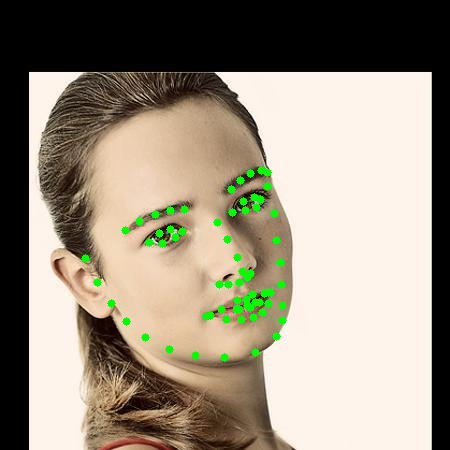

In [11]:
# choosing random image from the testing data
image_name = random.choice(file_names)
# reading the image
image='/content/AFLW2000/' + image_name + '.jpg'
frame = cv2.imread(image)
# reading the true labels and drawing the axis on the image
mat = sio.loadmat('/content/AFLW2000/' + image_name + '.mat')

pt3d=mat['pt3d_68']
x_points = pt3d[0]
y_points = pt3d[1]
for j in range(len(x_points)):
  cv2.circle(frame, (int(x_points[j]),int(y_points[j])), radius=0, color=(0,255,0), thickness=7)

cv2_imshow(frame)

### 6.2 Drawing the 3 axis from the true labels

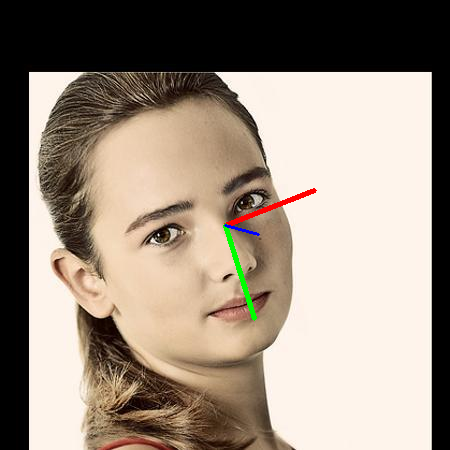

In [12]:
# reading the image
image='/content/AFLW2000/' + image_name + '.jpg'
frame = cv2.imread(image)
# reading the true labels and drawing the axis on the image
mat = sio.loadmat('/content/AFLW2000/' + image_name + '.mat')
pitch_true = mat["Pose_Para"][0][0]
yaw_true = mat["Pose_Para"][0][1]
roll_true = mat["Pose_Para"][0][2]
cv2.destroyAllWindows()
cv2_imshow(draw_axis(frame,pitch_true,yaw_true,roll_true))
cv2.destroyAllWindows()

### 6.3 Drawing the 3 axis from the predicted labels

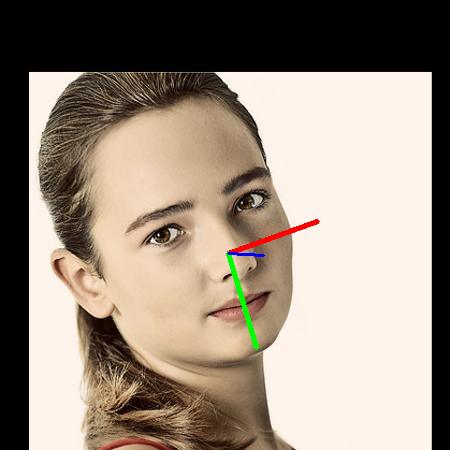

In [13]:
# reading the image
image='/content/AFLW2000/' + image_name + '.jpg'
frame = cv2.imread(image)
# converting the image from BGR to RGB
cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
# detecting the face for predicting the points
dets = cnn_face_detector(cv2_frame, 1)
x1 = dets[0].left()
y1 = dets[0].top()
x2 = dets[0].right()
y2 = dets[0].bottom()
tdx = x1 + int((x2 - x1)/2)
tdy = y1 + int((y2 - y1)/2)
# predicting the landmarks
shape = predictor(cv2_frame, dets[0])
x = []
y = []
# looping over the x and y points and appending them to x and y lists
for i in range(68):
  x.append(shape.part(i).x)
  y.append(shape.part(i).y)

# converting the two lists to array and stacking them horizontally
x = np.array(x)
y = np.array(y)
points = np.hstack([x,y]).reshape(1,-1)
# predicting the 3 angels to draw the axis on the image
pred_pitch = pitch_model.predict(points)
pred_yaw = yaw_model.predict(points)
pred_roll = roll_model.predict(points)

cv2.destroyAllWindows()
cv2_imshow(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,tdx,tdy))
cv2.destroyAllWindows()

## 7. Testing the models on test video and drawing the 3 axis

In [14]:
# loading the test video
%%capture
!git clone https://github.com/MarwanMohamed95/Head-Pose-Estimation

In [16]:
# Create a VideoCapture object and read from input file
cap = cv2.VideoCapture('/content/Head-Pose-Estimation/Test Input.mp4')
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video file")

# initializing a list to store the frames   
img_array = []
# Read until video is completed
while(cap.isOpened()):   
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        cv2_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        dets = cnn_face_detector(cv2_frame, 1)  
        
        try:
          x1 = dets[0].left()
          y1 = dets[0].top()
          x2 = dets[0].right()
          y2 = dets[0].bottom()
          tdx = x1 + int((x2 - x1)/2)
          tdy = y1 + int((y2 - y1)/2)
          shape = predictor(cv2_frame, dets[0])
          x = []
          y = []
          # looping over the x and y points and appending them to x and y lists
          for i in range(68):
            x.append(shape.part(i).x)
            y.append(shape.part(i).y)

          # converting the two lists to array and stacking them horizontally
          x = np.array(x)
          y = np.array(y)
          points = np.hstack([x,y]).reshape(1,-1)
          # predicting the 3 angels to draw the axis on the image
          
          pitch = pitch_model.predict(points)
          yaw = yaw_model.predict(points)
          roll = roll_model.predict(points)
          draw_axis(frame,pitch,yaw,roll,tdx,tdy)
          # appending the result frame to the img_array list
          img_array.append(frame)
        except:
          draw_axis(frame,pitch,yaw,roll,tdx,tdy)

  # Break the loop
    else: 
        break

cap.release()  
# Closes all the frames
cv2.destroyAllWindows()

In [17]:
# converting the frames to video
out = cv2.VideoWriter('Test Output 2.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (450,450))
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()